## Import Libraries

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pylab import rcParams
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
import xgboost as xgb
import os
from sklearn.metrics import mean_squared_error

### Company selection

In [2]:
comp = pd.read_csv('securities.csv')
comp.head()

,Ticker symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Address of Headquarters,Date first added,CIK
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",NaN,66740
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152
3,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373
4,ATVI,Activision Blizzard,reports,Information Technology,Home Entertainment Software,"Santa Monica, California",2015-08-31,718877


As referred in report, 5 companies in the airline industry are selected: American Airlines Group, Southwest Airlines, United Continental Holdings, Delta Air Lines, and Alaska Air Group Inc. 

In [3]:
##find corresponding symbol for each company in the order A-Z
comp_5 = comp.loc[(comp['Security'] == 'Alaska Air Group Inc') | 
                  (comp['Security'] == 'American Airlines Group') | 
                  (comp['Security'] == 'Delta Air Lines') | 
                  (comp['Security'] == 'Southwest Airlines') | 
                  (comp['Security'] == 'United Continental Holdings'), ['Ticker symbol']]
print(comp_5)


    Ticker symbol
15            ALK
28            AAL
137           DAL
411           LUV
458           UAL


## Read Data

In [4]:
df = pd.read_csv('prices-split-adjusted.csv')

In [5]:
df.head().round(3)

,date,symbol,open,close,low,high,volume
0,2016-01-05,WLTW,123.43,125.84,122.31,126.25,2163600.0
1,2016-01-06,WLTW,125.24,119.98,119.94,125.54,2386400.0
2,2016-01-07,WLTW,116.38,114.95,114.93,119.74,2489500.0
3,2016-01-08,WLTW,115.48,116.62,113.50,117.44,2006300.0
4,2016-01-11,WLTW,117.01,114.97,114.09,117.33,1408600.0


In [6]:
#check the shape of loaded dataset
print(df.shape)

(851264, 7)


### check data quality

Find out if there are missing data:

In [7]:
#there are no missing data. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [8]:
df[df.isnull().any(axis=1)]

,date,symbol,open,close,low,high,volume


In [9]:
##find out unique symbols info
q = df.symbol.unique()
print("number of unique symbols:", len(q))
print("first 10 unique symbols are:", q[0:10])

number of unique symbols: 501
first 10 unique symbols are: ['WLTW' 'A' 'AAL' 'AAP' 'AAPL' 'ABC' 'ABT' 'ACN' 'ADBE' 'ADI']


## Visualization of opening and closing stock prices for each company

In [10]:
def visualization(i):
    company_data = df.loc[df['symbol'] == i]
    company_data_open = np.array(company_data['open']).reshape(-1,1)
    company_data_close = np.array(company_data['close']).reshape(-1,1)
    plt.subplot(2, 1, 1)
    ax = df.plot
    plt.plot(company_data_open)
    plt.xlabel('Time')
    plt.ylabel(i + 'opening stock price')
    
    plt.subplot(2, 1, 2)
    plt.plot(company_data_close)
    plt.xlabel('Time')
    plt.ylabel(i + 'closing stock price')
    
    plt.show()

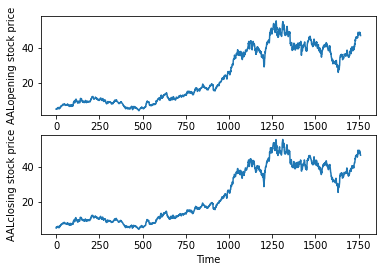

In [11]:
visualization('AAL')

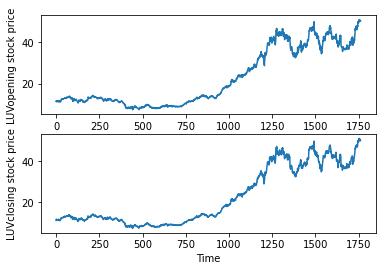

In [12]:
visualization('LUV')

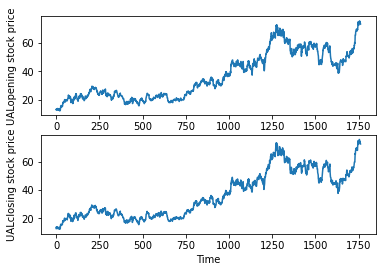

In [13]:
visualization('UAL')

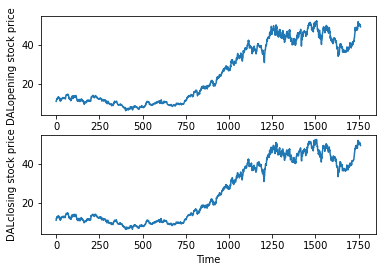

In [14]:
visualization('DAL')

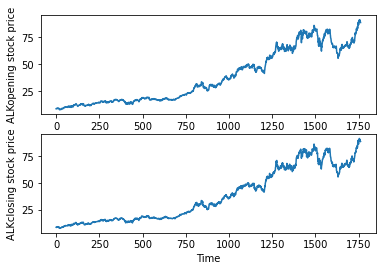

In [15]:
visualization('ALK')

Above plots show that the differences between opening and closing prices are marginal, closing price is selected as TARGET as explained in the report

To better visualize the stock price over time, adjust the x-axis to date format

In [16]:
df.loc[:,'date']=pd.to_datetime(df['date'],format='%Y-%m-%d')
df['month'] = df['date'].dt.month
df.head()

,date,symbol,open,close,low,high,volume,month
0,2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0,1
1,2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0,1
2,2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0,1
3,2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0,1
4,2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0,1


### Generate Dataframes for each company

In [17]:
ALK = df.loc[df['symbol'] == 'ALK']
AAL = df.loc[df['symbol'] == 'AAL']
DAL = df.loc[df['symbol'] == 'DAL']
LUV = df.loc[df['symbol'] == 'LUV']
UAL = df.loc[df['symbol'] == 'UAL']

In [18]:
#view summary stats for random company
LUV.describe()

,open,close,low,high,volume,month
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03,1762.000000
mean,22.489109,22.489387,22.198649,22.769098,7.711555e+06,6.549943
std,13.780502,13.783337,13.598771,13.954358,3.598728e+06,3.426034
min,7.370000,7.350000,7.150000,7.550000,1.475000e+06,1.000000
25%,11.380000,11.400000,11.230000,11.550000,5.458375e+06,4.000000
50%,13.820000,13.810000,13.690000,13.945000,7.000200e+06,7.000000
75%,37.457499,37.327501,36.777499,37.947501,9.006950e+06,10.000000
max,50.770000,50.889999,50.520000,51.340000,4.382490e+07,12.000000


In [19]:
LUV.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1762 entries, 516 to 851045
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    1762 non-null   datetime64[ns]
 1   symbol  1762 non-null   object        
 2   open    1762 non-null   float64       
 3   close   1762 non-null   float64       
 4   low     1762 non-null   float64       
 5   high    1762 non-null   float64       
 6   volume  1762 non-null   float64       
 7   month   1762 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 123.9+ KB


## train, validation test set split

In [20]:
test_size = 0.2
valid_size=0.2
num_test = int(test_size*len(df))
num_valid = int(valid_size * len(df))
num_train = len(df) - num_test-num_valid

##split dataset
train = df[:num_train]
valid = df[num_train:num_train + num_valid]
test = df[num_train + num_valid:]
trainvalid = df[:num_train + num_valid]
print("shape of train:",train.shape)
print("shape of test:", test.shape)
print("shape of validation:", valid.shape)
print("shape of train and validation:", trainvalid.shape)

shape of train: (510760, 8)
shape of test: (170252, 8)
shape of validation: (170252, 8)
shape of train and validation: (681012, 8)


In [21]:
##create table for each comopany
#AAL
AALtrain = train.loc[train['symbol'] == 'AAL']
AALvalid = valid.loc[valid['symbol'] == 'AAL']
AALtest = test.loc[test['symbol'] == 'AAL']
AALtrainvalid = trainvalid.loc[trainvalid['symbol'] == 'AAL']

#LUV
LUVtrain = train.loc[train['symbol'] == 'LUV']
LUVvalid = valid.loc[valid['symbol'] == 'LUV']
LUVtest = test.loc[test['symbol'] == 'LUV']
LUVtrainvalid = trainvalid.loc[trainvalid['symbol'] == 'LUV']

#UAL
UALtrain = train.loc[train['symbol'] == 'UAL']
UALvalid = valid.loc[valid['symbol'] == 'UAL']
UALtest = test.loc[test['symbol'] == 'UAL']
UALtrainvalid = trainvalid.loc[trainvalid['symbol'] == 'UAL']

#DAL
DALtrain = train.loc[train['symbol'] == 'DAL']
DALvalid = valid.loc[valid['symbol'] == 'DAL']
DALtest = test.loc[test['symbol'] == 'DAL']
DALtrainvalid = trainvalid.loc[trainvalid['symbol'] == 'DAL']

#ALK
ALKtrain = train.loc[train['symbol'] == 'ALK']
ALKvalid = valid.loc[valid['symbol'] == 'ALK']
ALKtest = test.loc[test['symbol'] == 'ALK']
ALKtrainvalid = trainvalid.loc[trainvalid['symbol'] == 'ALK']

In [22]:
AALtrain

,date,symbol,open,close,low,high,volume,month
252,2010-01-04,AAL,4.840000,4.770000,4.660000,4.940000,9837300.0,1
719,2010-01-05,AAL,4.790000,5.310000,4.710000,5.370000,25212000.0,1
1187,2010-01-06,AAL,5.190000,5.090000,5.000000,5.380000,16597900.0,1
1655,2010-01-07,AAL,5.060000,5.240000,5.050000,5.430000,14033400.0,1
2123,2010-01-08,AAL,5.270000,5.140000,5.060000,5.430000,12760000.0,1
...,...,...,...,...,...,...,...,...
508314,2014-04-04,AAL,37.410000,36.560001,36.299999,37.720001,8731000.0,4
508804,2014-04-07,AAL,36.779999,35.779999,35.459999,37.480000,10569800.0,4
509294,2014-04-08,AAL,36.000000,35.980000,33.619999,36.220001,17409200.0,4
509784,2014-04-09,AAL,36.080002,36.900002,35.160000,37.000000,11473300.0,4


In [23]:
print("shape of AALtrain:",AALtrain.shape)
print("shape of AALtest:", AALtest.shape)
print("shape of AALvalid:",AALvalid.shape)
print("shape of AALtrainvalid:", AALtrainvalid.shape)

shape of AALtrain: (1075, 8)
shape of AALtest: (341, 8)
shape of AALvalid: (346, 8)
shape of AALtrainvalid: (1421, 8)


### Feature Scaling

In [48]:
#normalization only on train data ----reason:information leaking
column = ['close', 'open', 'low', 'high', 'volume']

In [50]:
scaler = MinMaxScaler(feature_range=(0,1))

In [51]:
AALtrain_scaled = scaler.fit_transform(AALtrain[column])
LUVtrain_scaled = scaler.fit_transform(LUVtrain[column])
UALtrain_scaled = scaler.fit_transform(UALtrain[column])
DALtrain_scaled = scaler.fit_transform(DALtrain[column])
ALKtrain_scaled = scaler.fit_transform(ALKtrain[column])

In [52]:
AALtrain_scaled

array([[0.02198744, 0.02412716, 0.02023706, 0.02456728, 0.11208299],
       [0.0374072 , 0.02270792, 0.02168257, 0.03657175, 0.31063839],
       [0.03112507, 0.03406188, 0.03006649, 0.03685092, 0.19939225],
       ...,
       [0.91319246, 0.9086006 , 0.85747325, 0.89782245, 0.20986972],
       [0.93946322, 0.91087145, 0.90199482, 0.91959796, 0.13321099],
       [0.89348946, 0.92847006, 0.88580511, 0.93020659, 0.19569226]])

In [53]:
#Convert Array to DataFrame
AALtrain_scaled = pd.DataFrame(AALtrain_scaled, columns = column)
LUVtrain_scaled = pd.DataFrame(LUVtrain_scaled, columns = column)
UALtrain_scaled = pd.DataFrame(UALtrain_scaled, columns = column)
DALtrain_scaled = pd.DataFrame(DALtrain_scaled, columns = column)
ALKtrain_scaled = pd.DataFrame(ALKtrain_scaled, columns = column)

In [54]:
ALKtrain_scaled

,close,open,low,high,volume
0,0.022238,0.021735,0.020256,0.020444,0.109925
1,0.034270,0.021357,0.022564,0.030822,0.206613
2,0.032191,0.030744,0.031795,0.032073,0.202066
3,0.030994,0.032634,0.031538,0.035449,0.193808
4,0.026458,0.030618,0.025641,0.030322,0.160589
...,...,...,...,...,...
1070,0.965856,1.000000,0.975256,0.993498,0.111194
1071,0.934232,0.960940,0.940128,0.966490,0.184653
1072,0.946705,0.941158,0.925641,0.939481,0.171492
1073,1.000000,0.957538,0.966410,0.997499,0.165553


In [55]:
AALtrain_scaled[['date','month']] = AALtrain.reset_index()[['date', 'month']]
LUVtrain_scaled[['date','month']] = LUVtrain.reset_index()[['date', 'month']]
UALtrain_scaled[['date','month']] = UALtrain.reset_index()[['date', 'month']]
DALtrain_scaled[['date','month']] = DALtrain.reset_index()[['date', 'month']]
ALKtrain_scaled[['date','month']] = ALKtrain.reset_index()[['date', 'month']]

In [56]:
AALtrain_scaled

,close,open,low,high,volume,date,month
0,0.021987,0.024127,0.020237,0.024567,0.112083,2010-01-04,1
1,0.037407,0.022708,0.021683,0.036572,0.310638,2010-01-05,1
2,0.031125,0.034062,0.030066,0.036851,0.199392,2010-01-06,1
3,0.035408,0.030372,0.031512,0.038247,0.166273,2010-01-07,1
4,0.032553,0.036333,0.031801,0.038247,0.149828,2010-01-08,1
...,...,...,...,...,...,...,...
1070,0.929754,0.948623,0.934952,0.939698,0.097796,2014-04-04,4
1071,0.907481,0.930741,0.910668,0.932998,0.121543,2014-04-07,4
1072,0.913192,0.908601,0.857473,0.897822,0.209870,2014-04-08,4
1073,0.939463,0.910871,0.901995,0.919598,0.133211,2014-04-09,4


example: plot scaled AAL train dataset close price over time

Text(0, 0.5, 'price')

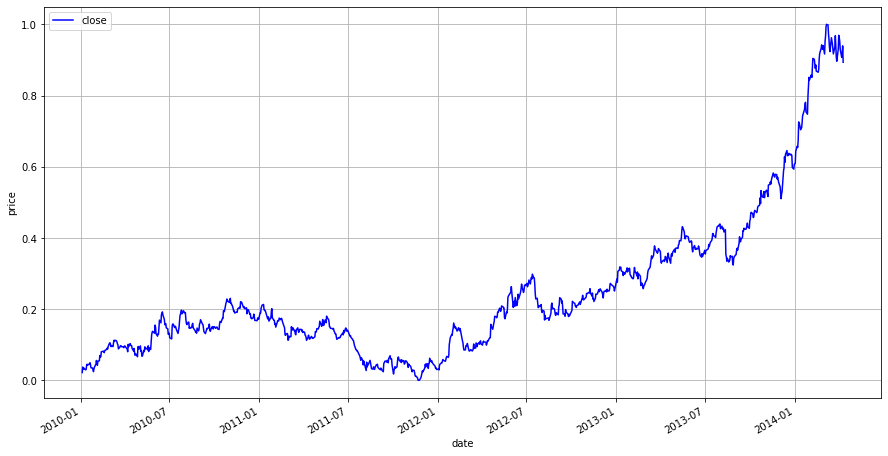

In [57]:
rcParams['figure.figsize']=15, 8

ax=AALtrain_scaled.plot(x='date', y='close', style='b-', grid=True)
ax.set_xlabel('date')
ax.set_ylabel('price')

For plotting all train, validation and test in same graph, data need to go through same normalization

In [83]:
##normalization for validation set
#AAL
AALvalid_scaled = scaler.fit_transform(AALvalid[column])
AALvalid_scaled = pd.DataFrame(AALvalid_scaled, columns = column)
AALvalid_scaled[['date', 'month']] = AALvalid.reset_index()[['date', 'month']]
print("AALvalid has shape:", AALvalid_scaled.shape)

#LUV
LUVvalid_scaled = scaler.fit_transform(LUVvalid[column])
LUVvalid_scaled = pd.DataFrame(LUVvalid_scaled, columns = column)
LUVvalid_scaled[['date', 'month']] = LUVvalid.reset_index()[['date', 'month']]
print("LUVvalid has shape:", LUVvalid_scaled.shape)

#UAL
UALvalid_scaled = scaler.fit_transform(UALvalid[column])
UALvalid_scaled = pd.DataFrame(UALvalid_scaled, columns = column)
UALvalid_scaled[['date', 'month']] = UALvalid.reset_index()[['date', 'month']]
print("UALvalid has shape:", UALvalid_scaled.shape)

#DAL
DALvalid_scaled = scaler.fit_transform(DALvalid[column])
DALvalid_scaled = pd.DataFrame(DALvalid_scaled, columns = column)
DALvalid_scaled[['date', 'month']] = DALvalid.reset_index()[['date', 'month']]
print("DALvalid has shape:", DALvalid_scaled.shape)

#ALK
ALKvalid_scaled = scaler.fit_transform(ALKvalid[column])
ALKvalid_scaled = pd.DataFrame(ALKvalid_scaled, columns = column)
ALKvalid_scaled[['date', 'month']] = ALKvalid.reset_index()[['date', 'month']]
print("ALKvalid has shape:", ALKvalid_scaled.shape)

AALvalid has shape: (346, 7)
LUVvalid has shape: (346, 7)
UALvalid has shape: (345, 7)
DALvalid has shape: (346, 7)
ALKvalid has shape: (346, 7)


In [84]:
##normalization for test set
AALtest_scaled = scaler.fit_transform(AALtest[column])
AALtest_scaled = pd.DataFrame(AALtest_scaled, columns = column)
AALtest_scaled[['date', 'month']] = AALtest.reset_index()[['date', 'month']]
AALtest_scaled.shape

(341, 7)

In [85]:
##for remaining four companies
#LUV
LUVtest_scaled = scaler.fit_transform(LUVtest[column])
LUVtest_scaled = pd.DataFrame(LUVtest_scaled, columns = column)
LUVtest_scaled[['date', 'month']] = LUVtest.reset_index()[['date', 'month']]
print("LUVtest has shape:", LUVtest_scaled.shape)

#UAL
UALtest_scaled = scaler.fit_transform(UALtest[column])
UALtest_scaled = pd.DataFrame(UALtest_scaled, columns = column)
UALtest_scaled[['date', 'month']] = UALtest.reset_index()[['date', 'month']]
print("UALtest has shape:", UALtest_scaled.shape)

#DAL
DALtest_scaled = scaler.fit_transform(DALtest[column])
DALtest_scaled = pd.DataFrame(DALtest_scaled, columns = column)
DALtest_scaled[['date', 'month']] = DALtest.reset_index()[['date', 'month']]
print("DALtest has shape:", DALtest_scaled.shape)

#ALK
ALKtest_scaled = scaler.fit_transform(ALKtest[column])
ALKtest_scaled = pd.DataFrame(ALKtest_scaled, columns = column)
ALKtest_scaled[['date', 'month']] = ALKtest.reset_index()[['date', 'month']]
print("ALKtest has shape:", ALKtest_scaled.shape)

LUVtest has shape: (341, 7)
UALtest has shape: (342, 7)
DALtest has shape: (341, 7)
ALKtest has shape: (341, 7)


In [86]:
##normalization for validation set and training set
#AAL
AALtrainvalid_scaled = scaler.fit_transform(AALtrainvalid[column])
AALtrainvalid_scaled = pd.DataFrame(AALtrainvalid_scaled, columns = column)
AALtrainvalid_scaled[['date', 'month']] = AALtrainvalid.reset_index()[['date', 'month']]
print("AALtrainvalid has shape:", AALtrainvalid_scaled.shape)

#LUV
LUVtrainvalid_scaled = scaler.fit_transform(LUVtrainvalid[column])
LUVtrainvalid_scaled = pd.DataFrame(LUVtrainvalid_scaled, columns = column)
LUVtrainvalid_scaled[['date', 'month']] = LUVtrainvalid.reset_index()[['date', 'month']]
print("LUVtrainvalid has shape:", LUVtrainvalid_scaled.shape)

#UAL
UALtrainvalid_scaled = scaler.fit_transform(UALtrainvalid[column])
UALtrainvalid_scaled = pd.DataFrame(UALtrainvalid_scaled, columns = column)
UALtrainvalid_scaled[['date', 'month']] = UALtrainvalid.reset_index()[['date', 'month']]
print("UALtrainvalid has shape:", UALtrainvalid_scaled.shape)

#DAL
DALtrainvalid_scaled = scaler.fit_transform(DALtrainvalid[column])
DALtrainvalid_scaled = pd.DataFrame(DALtrainvalid_scaled, columns = column)
DALtrainvalid_scaled[['date', 'month']] = DALtrainvalid.reset_index()[['date', 'month']]
print("DALtrainvalid has shape:", DALtrainvalid_scaled.shape)

#ALK
ALKtrainvalid_scaled = scaler.fit_transform(ALKtrainvalid[column])
ALKtrainvalid_scaled = pd.DataFrame(ALKtrainvalid_scaled, columns = column)
ALKtrainvalid_scaled[['date', 'month']] = ALKtrainvalid.reset_index()[['date', 'month']]
print("ALKtrainvalid has shape:", ALKtrainvalid_scaled.shape)

AALtrainvalid has shape: (1421, 7)
LUVtrainvalid has shape: (1421, 7)
UALtrainvalid has shape: (1420, 7)
DALtrainvalid has shape: (1421, 7)
ALKtrainvalid has shape: (1421, 7)


Text(0.5, 1.0, 'Scaling with train+validation and test set')

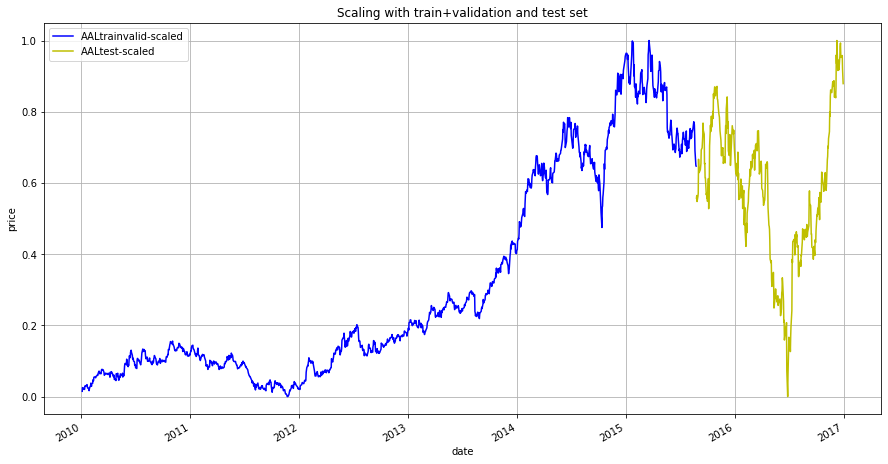

In [87]:
rcParams['figure.figsize']=15, 8

ax=AALtrainvalid_scaled.plot(x='date', y='close', style='b-', grid=True)
ax=AALtest_scaled.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax.legend(['AALtrainvalid-scaled','AALtest-scaled'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Scaling with train+validation and test set')

Text(0.5, 1.0, 'Scaling with train, validation, test set')

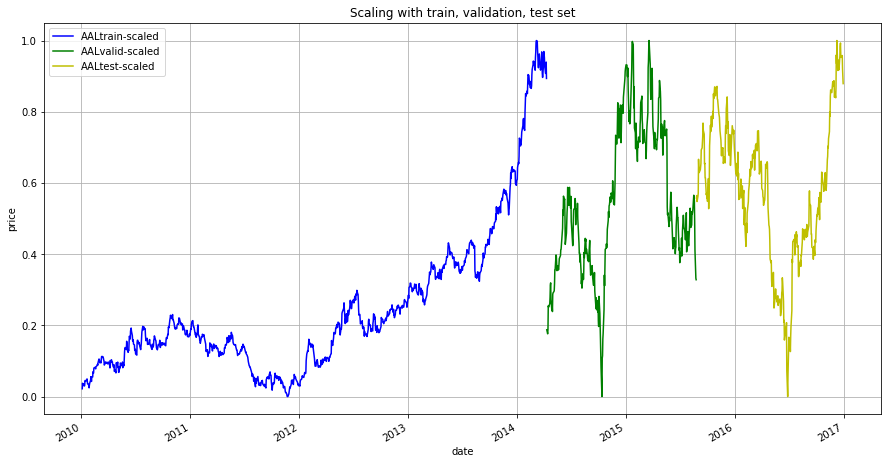

In [88]:
rcParams['figure.figsize']=15, 8

ax=AALtrain_scaled.plot(x='date', y='close', style='b-', grid=True)
ax=AALvalid_scaled.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax=AALtest_scaled.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax.legend(['AALtrain-scaled','AALvalid-scaled','AALtest-scaled'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('Scaling with train, validation, test set')

Text(0.5, 1.0, 'without scaling with train+validation and test set')

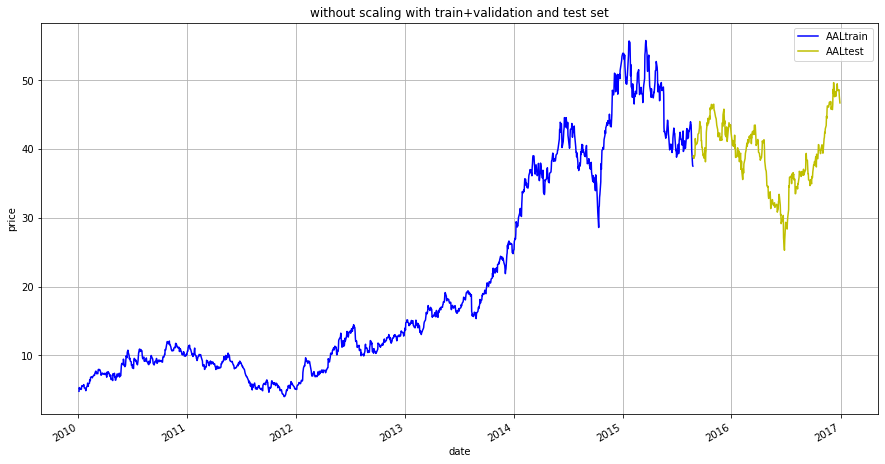

In [89]:
rcParams['figure.figsize']=15, 8

ax=AALtrainvalid.plot(x='date', y='close', style='b-', grid=True)
ax=AALtest.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax.legend(['AALtrain','AALtest'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('without scaling with train+validation and test set')

Text(0.5, 1.0, 'without scaling with train, validation and test set')

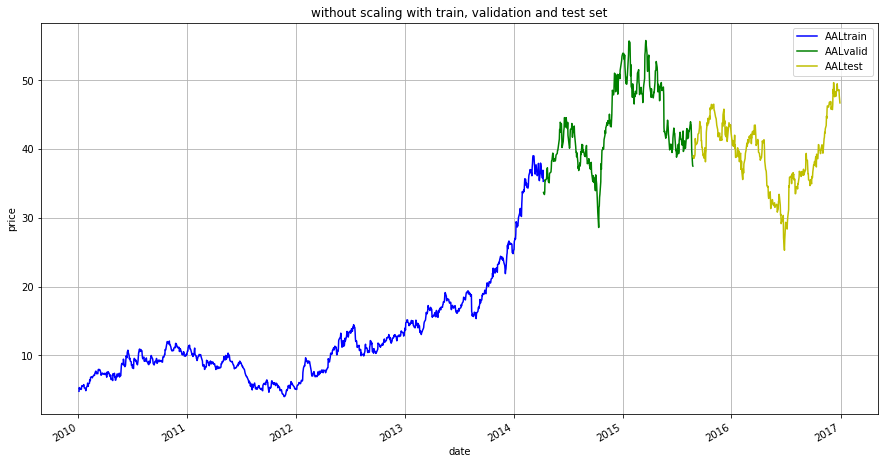

In [90]:
rcParams['figure.figsize']=15, 8

ax=AALtrain.plot(x='date', y='close', style='b-', grid=True)
ax=AALvalid.plot(x='date', y='close', style='g-', grid=True, ax=ax)
ax=AALtest.plot(x='date', y='close', style='y-', grid=True, ax=ax)
ax.legend(['AALtrain','AALvalid','AALtest'])
ax.set_xlabel('date')
ax.set_ylabel('price')
ax.set_title('without scaling with train, validation and test set')

## Generate Features and Objectives

In [91]:
AALtrain_scaled

,close,open,low,high,volume,date,month
0,0.021987,0.024127,0.020237,0.024567,0.112083,2010-01-04,1
1,0.037407,0.022708,0.021683,0.036572,0.310638,2010-01-05,1
2,0.031125,0.034062,0.030066,0.036851,0.199392,2010-01-06,1
3,0.035408,0.030372,0.031512,0.038247,0.166273,2010-01-07,1
4,0.032553,0.036333,0.031801,0.038247,0.149828,2010-01-08,1
...,...,...,...,...,...,...,...
1070,0.929754,0.948623,0.934952,0.939698,0.097796,2014-04-04,4
1071,0.907481,0.930741,0.910668,0.932998,0.121543,2014-04-07,4
1072,0.913192,0.908601,0.857473,0.897822,0.209870,2014-04-08,4
1073,0.939463,0.910871,0.901995,0.919598,0.133211,2014-04-09,4


In [92]:
obj = 'close'
features = ['open', 'high', 'low', 'volume']

In [94]:
#AAL
AALxtrain = AALtrain[features]
AALytrain = AALtrain[obj]
AALxvalid= AALvalid[features]
AALyvalid = AALvalid[obj]
AALxtest = AALtest[features]
AALytest = AALtest[obj]
AALxtrainvalid = AALtrainvalid[features]
AALytrainvalid = AALtrainvalid[obj]

#LUV
LUVxtrain = LUVtrain[features]
LUVytrain = LUVtrain[obj]
LUVxvalid = LUVvalid[features]
LUVyvalid = LUVvalid[obj]
LUVxtest = LUVtest[features]
LUVytest = LUVtest[obj]
LUVxtrainvalid = LUVtrainvalid[features]
LUVytrainvalid = LUVtrainvalid[obj]

#UAL
UALxtrain = UALtrain[features]
UALytrain = UALtrain[obj]
UALxvalid = UALvalid[features]
UALyvalid = UALvalid[obj]
UALxtest = UALtest[features]
UALytest = UALtest[obj]
UALxtrainvalid = UALtrainvalid[features]
UALytrainvalid = UALtrainvalid[obj]

#DAL
DALxtrain = DALtrain[features]
DALytrain = DALtrain[obj]
DALxvalid = DALvalid[features]
DALyvalid = DALvalid[obj]
DALxtest = DALtest[features]
DALytest = DALtest[obj]
DALxtrainvalid = DALtrainvalid[features]
DALytrainvalid = DALtrainvalid[obj]

#ALK
ALKxtrain = ALKtrain[features]
ALKytrain = ALKtrain[obj]
ALKxvalid = ALKvalid[features]
ALKyvalid = ALKvalid[obj]
ALKxtest = ALKtest[features]
ALKytest = ALKtest[obj]
ALKxtrainvalid = ALKtrainvalid[features]
ALKytrainvalid = ALKtrainvalid[obj]


In [95]:
print('for AAL, x train has shape:', AALxtrain.shape)
print('for AAL, y train has shape:', AALytrain.shape)
print('for AAL, x valid has shape:', AALxvalid.shape)
print('for AAL, y valid has shape:', AALyvalid.shape)
print('for AAL, x test has shape:', AALxtest.shape)
print('for AAL, y test has shape:', AALytest.shape)
print('for AAL, x trainvalid has shape:', AALxtrainvalid.shape)
print('for AAL, y trainvalid has shape:', AALytrainvalid.shape)

for AAL, x train has shape: (1075, 4)
for AAL, y train has shape: (1075,)
for AAL, x valid has shape: (346, 4)
for AAL, y valid has shape: (346,)
for AAL, x test has shape: (341, 4)
for AAL, y test has shape: (341,)
for AAL, x trainvalid has shape: (1421, 4)
for AAL, y trainvalid has shape: (1421,)


### generate features and target for data after normalization

In [96]:
#AAL
AALxtrain_scaled = AALtrain_scaled[features]
AALytrain_scaled = AALtrain_scaled[obj]
AALxvalid_scaled = AALvalid_scaled[features]
AALyvalid_scaled = AALvalid_scaled[obj]
AALxtest_scaled = AALtest_scaled[features]
AALytest_scaled = AALtest_scaled[obj]
AALxtrainvalid_scaled = AALtrainvalid_scaled[features]
AALytrainvalid_scaled = AALtrainvalid_scaled[obj]

#LUV
LUVxtrain_scaled = LUVtrain_scaled[features]
LUVytrain_scaled = LUVtrain_scaled[obj]
LUVxvalid_scaled = LUVvalid_scaled[features]
LUVyvalid_scaled = LUVvalid_scaled[obj]
LUVxtest_scaled = LUVtest_scaled[features]
LUVytest_scaled = LUVtest_scaled[obj]
LUVxtrainvalid_scaled = LUVtrainvalid_scaled[features]
LUVytrainvalid_scaled = LUVtrainvalid_scaled[obj]

#UAL
UALxtrain_scaled = UALtrain_scaled[features]
UALytrain_scaled = UALtrain_scaled[obj]
UALxvalid_scaled = UALvalid_scaled[features]
UALyvalid_scaled = UALvalid_scaled[obj]
UALxtest_scaled = UALtest_scaled[features]
UALytest_scaled = UALtest_scaled[obj]
UALxtrainvalid_scaled = UALtrainvalid_scaled[features]
UALytrainvalid_scaled = UALtrainvalid_scaled[obj]

#DAL
DALxtrain_scaled = DALtrain_scaled[features]
DALytrain_scaled = DALtrain_scaled[obj]
DALxvalid_scaled = DALvalid_scaled[features]
DALyvalid_scaled = DALvalid_scaled[obj]
DALxtest_scaled = DALtest_scaled[features]
DALytest_scaled = DALtest_scaled[obj]
DALxtrainvalid_scaled = DALtrainvalid_scaled[features]
DALytrainvalid_scaled = DALtrainvalid_scaled[obj]

#ALK
ALKxtrain_scaled = ALKtrain_scaled[features]
ALKytrain_scaled = ALKtrain_scaled[obj]
ALKxvalid_scaled = ALKvalid_scaled[features]
ALKyvalid_scaled = ALKvalid_scaled[obj]
ALKxtest_scaled = ALKtest_scaled[features]
ALKytest_scaled = ALKtest_scaled[obj]
ALKxtrainvalid_scaled = ALKtrainvalid_scaled[features]
ALKytrainvalid_scaled = ALKtrainvalid_scaled[obj]


In [97]:
print('for AAL, x train_scaled has shape:', AALxtrain_scaled.shape)
print('for AAL, y train_scaled has shape:', AALytrain_scaled.shape)
print('for AAL, x valid_scaled has shape:', AALxvalid_scaled.shape)
print('for AAL, y valid_scaled has shape:', AALyvalid_scaled.shape)
print('for AAL, x test_scaled has shape:', AALxtest_scaled.shape)
print('for AAL, y test_scaled has shape:', AALytest_scaled.shape)
print('for AAL, x trainvalid_scaled has shape:', AALxtrainvalid_scaled.shape)
print('for AAL, y trainvalid_scaled has shape:', AALytrainvalid_scaled.shape)

for AAL, x train_scaled has shape: (1075, 4)
for AAL, y train_scaled has shape: (1075,)
for AAL, x valid_scaled has shape: (346, 4)
for AAL, y valid_scaled has shape: (346,)
for AAL, x test_scaled has shape: (341, 4)
for AAL, y test_scaled has shape: (341,)
for AAL, x trainvalid_scaled has shape: (1421, 4)
for AAL, y trainvalid_scaled has shape: (1421,)


In [98]:
AALxtrain_scaled

,open,high,low,volume
0,0.024127,0.024567,0.020237,0.112083
1,0.022708,0.036572,0.021683,0.310638
2,0.034062,0.036851,0.030066,0.199392
3,0.030372,0.038247,0.031512,0.166273
4,0.036333,0.038247,0.031801,0.149828
...,...,...,...,...
1070,0.948623,0.939698,0.934952,0.097796
1071,0.930741,0.932998,0.910668,0.121543
1072,0.908601,0.897822,0.857473,0.209870
1073,0.910871,0.919598,0.901995,0.133211


### XGBoost model

Training model: before fine-tuning

AAL

In [99]:
algo_xgb_AAL = xgb.XGBRegressor(verbosity=0)
algo_xgb_AAL

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=0)

In [100]:
algo_xgb_AAL.fit(AALxtrain, AALytrain)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)

In [107]:
AALscore = algo_xgb_AAL.score(AALxtrain, AALytrain)
print('AAL training score:', AALscore)

AAL training score: 0.9999692135010905


In [108]:
algo_xgb_AAL_scaled = xgb.XGBRegressor(verbosity=0)
algo_xgb_AAL_scaled.fit(AALxtrain_scaled, AALytrain_scaled)
AALscore_scaled = algo_xgb_AAL_scaled.score(AALxtrain_scaled, AALytrain_scaled)
print('AAL training score scaled:', AALscore_scaled)

AAL training score scaled: 0.9999328570630838


In [134]:
#apply 10-fold cross validation
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(algo_xgb_AAL, AALxtrain, AALytrain, cv=kfold)
print('AAL k-fold CV average training score:%.4f' %kf_cv_scores.mean())


AAL k-fold CV average training score:0.9987


In [133]:
#apply 10-fold cross validation
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores_scaled = cross_val_score(algo_xgb_AAL_scaled, AALxtrain_scaled, AALytrain_scaled, cv=kfold)
print('AAL k-fold CV average training score scaled:%.4f' %kf_cv_scores_scaled.mean())

AAL k-fold CV average training score scaled:0.9987


### predict the test data

In [132]:
AALypred = algo_xgb_AAL.predict(AALxtest)
mse = mean_squared_error(AALytest, AALypred)
print('AAL MSE: %.4f'% mse)

AAL MSE: 13.7337


In [131]:
AALypred_scaled = algo_xgb_AAL_scaled.predict(AALxtest_scaled)
mse_scaled = mean_squared_error(AALytest_scaled, AALypred_scaled)
print('AAL MSE scaled: %.4f'% mse_scaled)

AAL MSE scaled: 0.0007


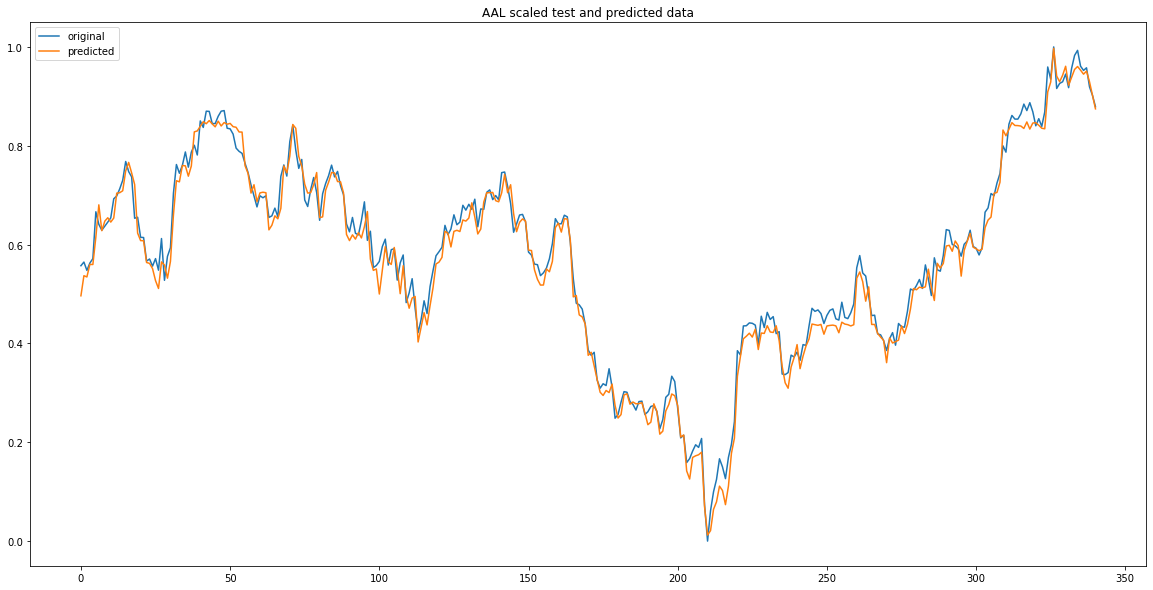

In [148]:
plt.figure(figsize=(20,10))
x_axis = range(len(AALytest))
plt.plot(x_axis, AALytest_scaled, label='original')
plt.plot(x_axis, AALypred_scaled, label='predicted')
plt.title('AAL scaled test and predicted data')
plt.legend()
plt.show()

LUV

In [113]:
algo_xgb_LUV = xgb.XGBRegressor(verbosity=0)
algo_xgb_LUV.fit(LUVxtrain, LUVytrain)
print(algo_xgb_LUV)
LUVscore = algo_xgb_LUV.score(LUVxtrain, LUVytrain)
print('LUV training score:', LUVscore)
algo_xgb_LUV_scaled = xgb.XGBRegressor(verbosity=0)
algo_xgb_LUV_scaled.fit(LUVxtrain_scaled, LUVytrain_scaled)
LUVscore_scaled = algo_xgb_LUV_scaled.score(LUVxtrain_scaled, LUVytrain_scaled)
print('LUV training score scaled:', LUVscore_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)
LUV training score: 0.9999639272811498
LUV training score scaled: 0.9999277789226446


In [130]:
#apply 10-fold cross validation
LUV_kf_cv_scores = cross_val_score(algo_xgb_LUV, LUVxtrain, LUVytrain, cv=kfold)
print('LUV k-fold CV average training score:%.4f' %LUV_kf_cv_scores.mean())
LUV_kf_cv_scores_scaled = cross_val_score(algo_xgb_LUV_scaled, LUVxtrain_scaled, LUVytrain_scaled, cv=kfold)
print('LUV k-fold CV average training score scaled:%.4f' %LUV_kf_cv_scores_scaled.mean())

LUV k-fold CV average training score:0.9984
LUV k-fold CV average training score scaled:0.9986


In [129]:
##predict the test data
LUVypred = algo_xgb_LUV.predict(LUVxtest)
LUVmse = mean_squared_error(LUVytest, LUVypred)
print('LUV MSE: %.4f'% LUVmse)
LUVypred_scaled = algo_xgb_LUV_scaled.predict(LUVxtest_scaled)
LUVmse_scaled = mean_squared_error(LUVytest_scaled, LUVypred_scaled)
print('LUV MSE scaled: %.4f'% LUVmse_scaled)

LUV MSE: 338.7739
LUV MSE scaled: 0.0010


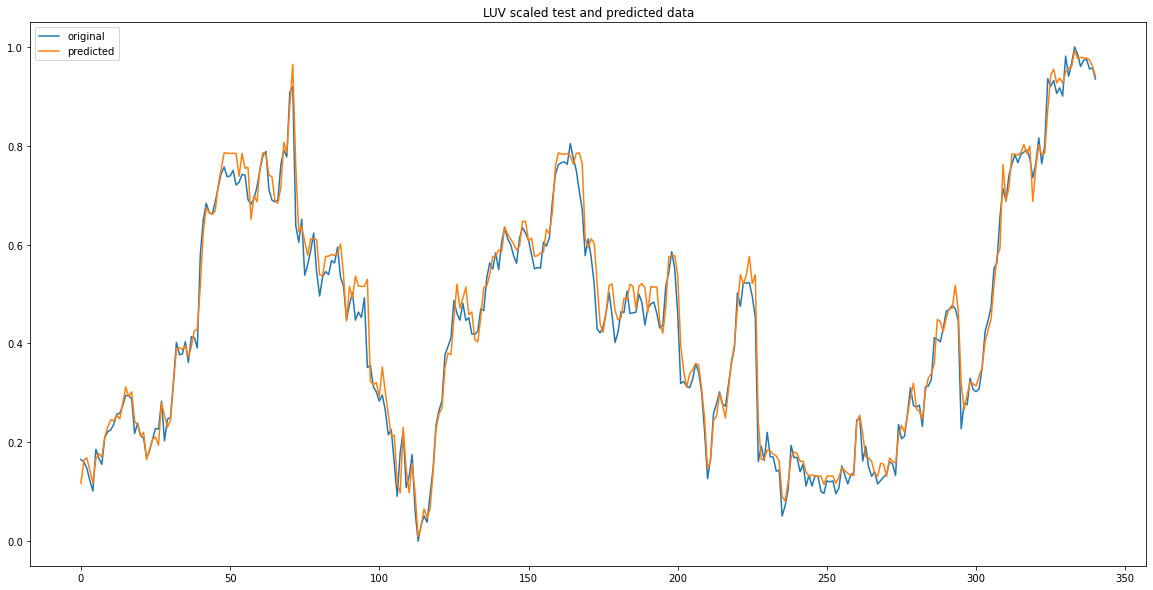

In [149]:
plt.figure(figsize=(20,10))
x_axis = range(len(LUVytest))
plt.plot(x_axis, LUVytest_scaled, label='original')
plt.plot(x_axis, LUVypred_scaled, label='predicted')
plt.title('LUV scaled test and predicted data')
plt.legend()
plt.show()

UAL

In [119]:
algo_xgb_UAL = xgb.XGBRegressor(verbosity=0)
algo_xgb_UAL.fit(UALxtrain, UALytrain)
print(algo_xgb_UAL)
UALscore = algo_xgb_UAL.score(UALxtrain, UALytrain)
print('UAL training score:', UALscore)
algo_xgb_UAL_scaled = xgb.XGBRegressor(verbosity=0)
algo_xgb_UAL_scaled.fit(UALxtrain_scaled, UALytrain_scaled)
UALscore_scaled = algo_xgb_UAL_scaled.score(UALxtrain_scaled, UALytrain_scaled)
print('UAL training score scaled:', UALscore_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)
UAL training score: 0.9999261593277797
UAL training score scaled: 0.999906380506807


In [128]:
#apply 10-fold cross validation
UAL_kf_cv_scores = cross_val_score(algo_xgb_UAL, UALxtrain, UALytrain, cv=kfold)
print('UAL k-fold CV average training score:%.4f' %UAL_kf_cv_scores.mean())
UAL_kf_cv_scores_scaled = cross_val_score(algo_xgb_UAL_scaled, UALxtrain_scaled, UALytrain_scaled, cv=kfold)
print('UAL k-fold CV average training score scaled:%.4f' %UAL_kf_cv_scores_scaled.mean())

UAL k-fold CV average training score:0.9970
UAL k-fold CV average training score scaled:0.9974


In [122]:
##predict the test data
UALypred = algo_xgb_UAL.predict(UALxtest)
UALmse = mean_squared_error(UALytest, UALypred)
print('UAL MSE: %.4f'% UALmse)
UALypred_scaled = algo_xgb_UAL_scaled.predict(UALxtest_scaled)
UALmse_scaled = mean_squared_error(UALytest_scaled, UALypred_scaled)
print('UAL MSE scaled: %.4f'% UALmse_scaled)

UAL MSE: 84.6066
UAL MSE scaled: 0.0003


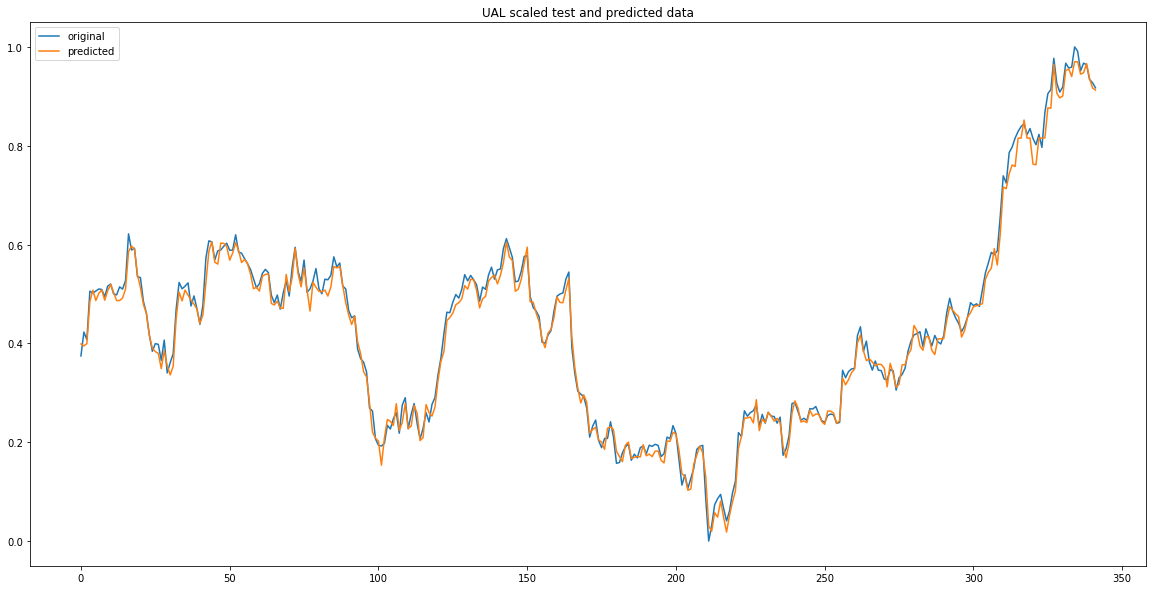

In [150]:
plt.figure(figsize=(20,10))
x_axis = range(len(UALytest))
plt.plot(x_axis, UALytest_scaled, label='original')
plt.plot(x_axis, UALypred_scaled, label='predicted')
plt.title('UAL scaled test and predicted data')
plt.legend()
plt.show()

DAL

In [124]:
algo_xgb_DAL = xgb.XGBRegressor(verbosity=0)
algo_xgb_DAL.fit(DALxtrain, DALytrain)
print(algo_xgb_DAL)
DALscore = algo_xgb_DAL.score(DALxtrain, DALytrain)
print('DAL training score:', DALscore)
algo_xgb_DAL_scaled = xgb.XGBRegressor(verbosity=0)
algo_xgb_DAL_scaled.fit(DALxtrain_scaled, DALytrain_scaled)
DALscore_scaled = algo_xgb_DAL_scaled.score(DALxtrain_scaled, DALytrain_scaled)
print('DAL training score scaled:', DALscore_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)
DAL training score: 0.999965727363418
DAL training score scaled: 0.999948071798456


In [126]:
#apply 10-fold cross validation
DAL_kf_cv_scores = cross_val_score(algo_xgb_DAL, DALxtrain, DALytrain, cv=kfold)
print('DAL k-fold CV average training score:%.4f' %DAL_kf_cv_scores.mean())
DAL_kf_cv_scores_scaled = cross_val_score(algo_xgb_DAL_scaled, DALxtrain_scaled, DALytrain_scaled, cv=kfold)
print('DAL k-fold CV average training score scaled:%.4f' %DAL_kf_cv_scores_scaled.mean())

DAL k-fold CV average training score:0.9987
DAL k-fold CV average training score scaled:0.9988


In [127]:
##predict the test data
DALypred = algo_xgb_DAL.predict(DALxtest)
DALmse = mean_squared_error(DALytest, DALypred)
print('DAL MSE: %.4f'% DALmse)
DALypred_scaled = algo_xgb_DAL_scaled.predict(DALxtest_scaled)
DALmse_scaled = mean_squared_error(DALytest_scaled, DALypred_scaled)
print('DAL MSE scaled: %.4f'% DALmse_scaled)

DAL MSE: 104.3579
DAL MSE scaled: 0.0007


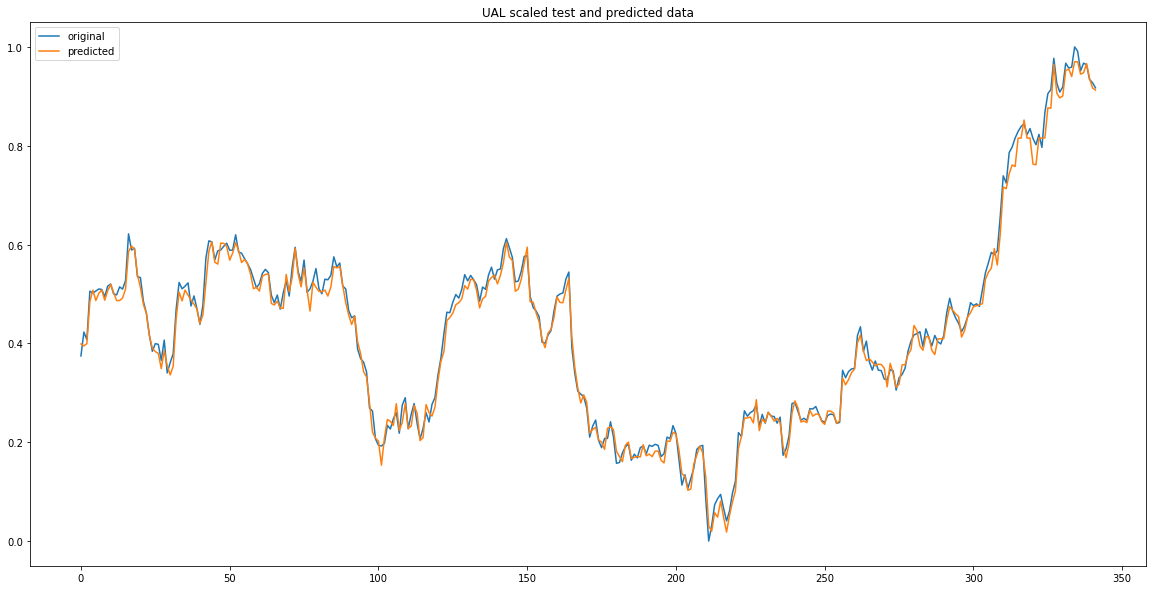

In [151]:
plt.figure(figsize=(20,10))
x_axis = range(len(UALytest))
plt.plot(x_axis, UALytest_scaled, label='original')
plt.plot(x_axis, UALypred_scaled, label='predicted')
plt.title('UAL scaled test and predicted data')
plt.legend()
plt.show()

ALK

In [135]:
algo_xgb_ALK = xgb.XGBRegressor(verbosity=0)
algo_xgb_ALK.fit(ALKxtrain, ALKytrain)
print(algo_xgb_ALK)
ALKscore = algo_xgb_ALK.score(ALKxtrain, ALKytrain)
print('ALK training score:', ALKscore)
algo_xgb_ALK_scaled = xgb.XGBRegressor(verbosity=0)
algo_xgb_ALK_scaled.fit(ALKxtrain_scaled, ALKytrain_scaled)
ALKscore_scaled = algo_xgb_ALK_scaled.score(ALKxtrain_scaled, ALKytrain_scaled)
print('ALK training score scaled:', ALKscore_scaled)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=0)
ALK training score: 0.9999740410564864
ALK training score scaled: 0.9999473254753911


In [136]:
#apply 10-fold cross validation
ALK_kf_cv_scores = cross_val_score(algo_xgb_ALK, ALKxtrain, ALKytrain, cv=kfold)
print('ALK k-fold CV average training score:%.4f' %ALK_kf_cv_scores.mean())
ALK_kf_cv_scores_scaled = cross_val_score(algo_xgb_ALK_scaled, ALKxtrain_scaled, ALKytrain_scaled, cv=kfold)
print('ALK k-fold CV average training score scaled:%.4f' %ALK_kf_cv_scores_scaled.mean())

ALK k-fold CV average training score:0.9990
ALK k-fold CV average training score scaled:0.9991


In [137]:
##predict the test data
ALKypred = algo_xgb_ALK.predict(ALKxtest)
ALKmse = mean_squared_error(ALKytest, ALKypred)
print('ALK MSE: %.4f'% ALKmse)
ALKypred_scaled = algo_xgb_ALK_scaled.predict(ALKxtest_scaled)
ALKmse_scaled = mean_squared_error(ALKytest_scaled, ALKypred_scaled)
print('ALK MSE scaled: %.4f'% ALKmse_scaled)

ALK MSE: 789.1001
ALK MSE scaled: 0.0007


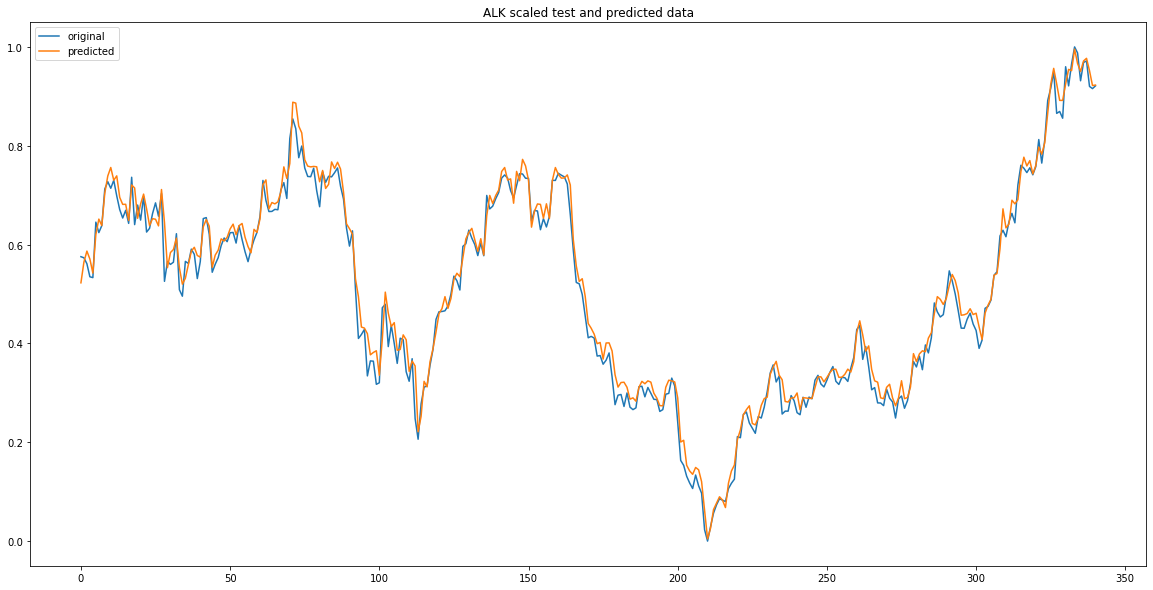

In [152]:
plt.figure(figsize=(20,10))
x_axis = range(len(ALKytest))
plt.plot(x_axis, ALKytest_scaled, label='original')
plt.plot(x_axis, ALKypred_scaled, label='predicted')
plt.title('ALK scaled test and predicted data')
plt.legend()
plt.show()

### Fine-tuning on AAL dataset, and applies best parameters on all five companies data in the future

In [142]:
parameters = {
    'n_estimators':[90, 100, 110, 120],
    'learning_rate':[0.1, 0.2, 0.3, 0.4],
    'max_depth':[5, 6, 7, 8],
    'gamma': [0, 0.1 ,0.2]
}
model = xgb.XGBRegressor(
                        n_estimators=100,
                        max_depth=6,
                        eval_metric='rmse',
                        learning_rate=0.3,
                        min_child_weight=1,
                        subsample=1,
                        colsample_bytree=1,
                        colsample_bylevel=1,
                        gamma=0)
tuning = GridSearchCV(estimator=model, param_grid=parameters,cv = 10, refit=True, scoring='neg_mean_squared_error' )
tuning.fit(AALxtrain_scaled, AALytrain_scaled)
print(f'Best parameters:{tuning.best_params_}')

Best parameters:{'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}


### Final model

In [143]:
xgb_AAL = xgb.XGBRegressor(
                           n_estimators=100,
                           max_depth=5,
                           learning_rate=0.2,
                           min_child_weight=1,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           gamma=0)
xgb_AAL.fit(AALxtrain_scaled, AALytrain_scaled)

##predict the test set
test_scaled_AAL_final = xgb_AAL.predict(AALxtest_scaled)
print('predictions on test set')
print(f'MSE test set AAL ={mean_squared_error(AALytest_scaled, test_scaled_AAL_final)}')
print('------------------------------------------------------')
print('predictions on test set before fine-tuning')
print(f'MSE test set AAL={mean_squared_error(AALytest_scaled, AALypred_scaled)}')

predictions on test set
MSE test set AAL =0.0005941722800295899
------------------------------------------------------
predictions on test set before fine-tuning
MSE test set AAL=0.0006505117424788368


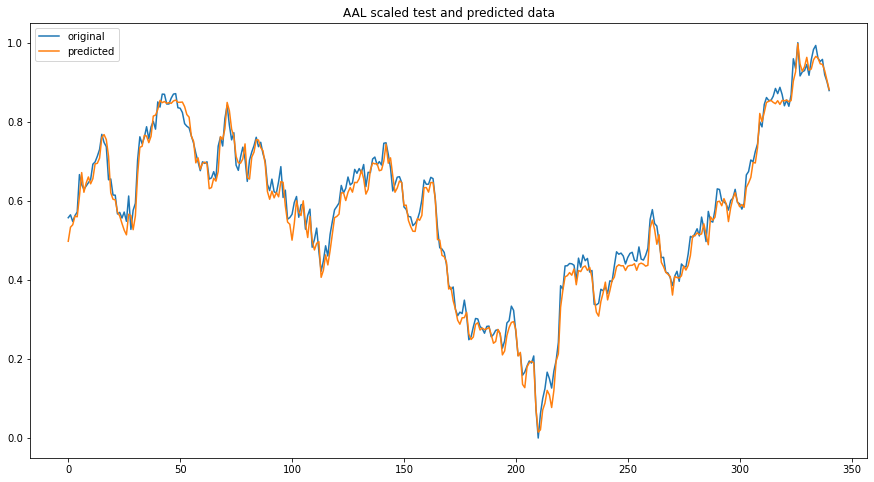

In [155]:
x_axis = range(len(AALytest_scaled))
plt.plot(x_axis, AALytest_scaled, label='original')
plt.plot(x_axis, test_scaled_AAL_final, label='predicted')
plt.title('AAL scaled test and predicted data')
plt.legend()
plt.show()

In [144]:
xgb_LUV = xgb.XGBRegressor(
                           n_estimators=100,
                           max_depth=5,
                           learning_rate=0.2,
                           min_child_weight=1,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           gamma=0)
xgb_LUV.fit(LUVxtrain_scaled, LUVytrain_scaled)
##predict the test set
test_scaled_LUV_final = xgb_LUV.predict(LUVxtest_scaled)
print('predictions on test set')
print(f'MSE test set LUV ={mean_squared_error(LUVytest_scaled, test_scaled_LUV_final)}')
print('------------------------------------------------------')
print('predictions on test set before fine-tuning')
print(f'MSE test set LUV={mean_squared_error(LUVytest_scaled, LUVypred_scaled)}')

predictions on test set
MSE test set LUV =0.0010692850789650193
------------------------------------------------------
predictions on test set before fine-tuning
MSE test set LUV=0.0010452295890224616


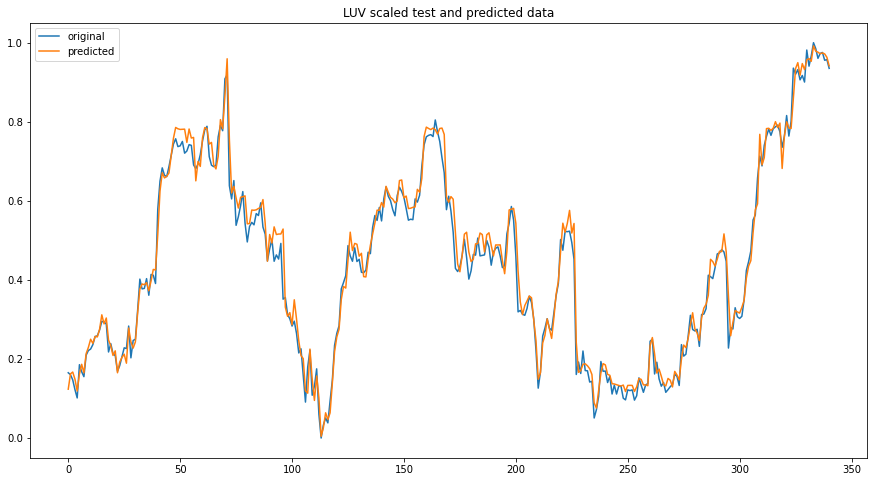

In [158]:
x_axis = range(len(LUVytest_scaled))
plt.plot(x_axis, LUVytest_scaled, label='original')
plt.plot(x_axis, test_scaled_LUV_final, label='predicted')
plt.title('LUV scaled test and predicted data')
plt.legend()
plt.show()

In [145]:
xgb_UAL = xgb.XGBRegressor(
                           n_estimators=100,
                           max_depth=5,
                           learning_rate=0.2,
                           min_child_weight=1,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           gamma=0)
xgb_UAL.fit(UALxtrain_scaled, UALytrain_scaled)


##predict the test set
test_scaled_UAL_final = xgb_UAL.predict(UALxtest_scaled)
print('predictions on test set')
print(f'MSE test set UAL ={mean_squared_error(UALytest_scaled, test_scaled_UAL_final)}')
print('------------------------------------------------------')
print('predictions on test set before fine-tuning')
print(f'MSE test set UAL={mean_squared_error(UALytest_scaled, UALypred_scaled)}')

predictions on test set
MSE test set UAL =0.0002795112156341605
------------------------------------------------------
predictions on test set before fine-tuning
MSE test set UAL=0.0003027614790752023


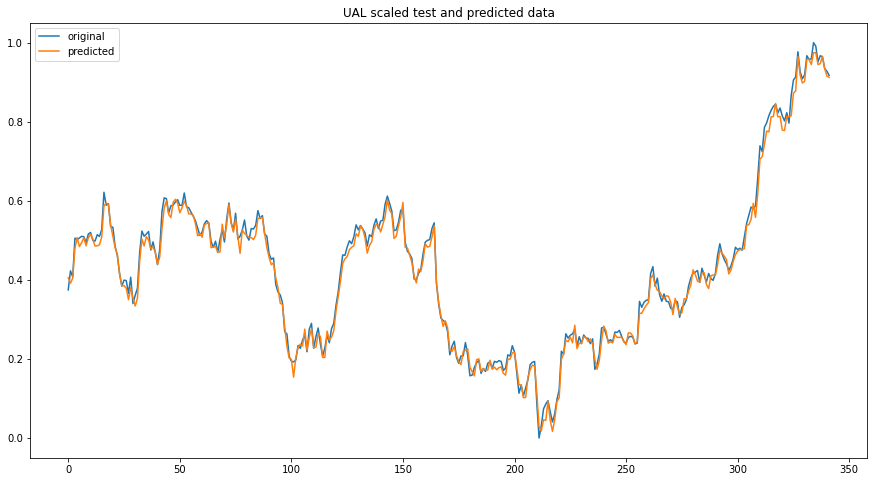

In [159]:
x_axis = range(len(UALytest_scaled))
plt.plot(x_axis, UALytest_scaled, label='original')
plt.plot(x_axis, test_scaled_UAL_final, label='predicted')
plt.title('UAL scaled test and predicted data')
plt.legend()
plt.show()

In [146]:
xgb_DAL = xgb.XGBRegressor(
                           n_estimators=100,
                           max_depth=5,
                           learning_rate=0.2,
                           min_child_weight=1,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           gamma=0)
xgb_DAL.fit(DALxtrain_scaled, DALytrain_scaled)


##predict the test set
test_scaled_DAL_final = xgb_DAL.predict(DALxtest_scaled)
print('predictions on test set')
print(f'MSE test set DAL ={mean_squared_error(DALytest_scaled, test_scaled_DAL_final)}')
print('------------------------------------------------------')
print('predictions on test set before fine-tuning')
print(f'MSE test set DAL={mean_squared_error(DALytest_scaled, DALypred_scaled)}')

predictions on test set
MSE test set DAL =0.0006487630704259879
------------------------------------------------------
predictions on test set before fine-tuning
MSE test set DAL=0.0006684792256336101


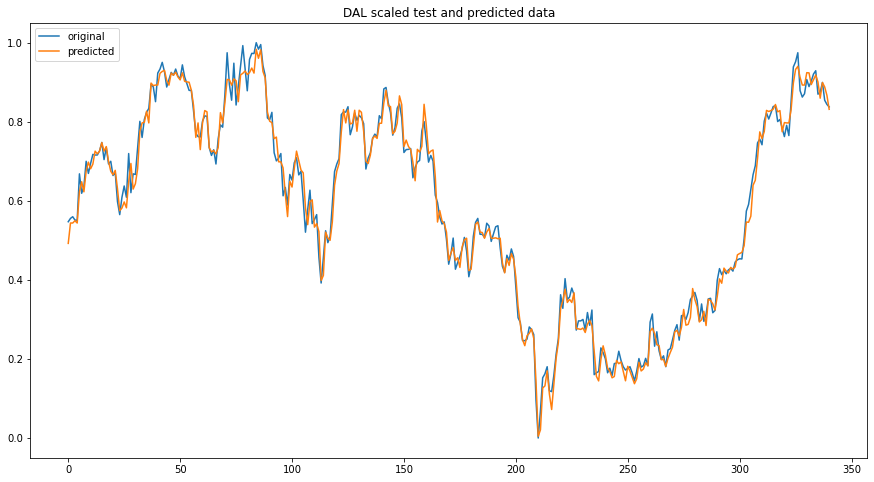

In [160]:
x_axis = range(len(DALytest_scaled))
plt.plot(x_axis, DALytest_scaled, label='original')
plt.plot(x_axis, test_scaled_DAL_final, label='predicted')
plt.title('DAL scaled test and predicted data')
plt.legend()
plt.show()

In [147]:
xgb_ALK = xgb.XGBRegressor(
                           n_estimators=100,
                           max_depth=5,
                           learning_rate=0.2,
                           min_child_weight=1,
                           subsample=1,
                           colsample_bytree=1,
                           colsample_bylevel=1,
                           gamma=0)
xgb_ALK.fit(ALKxtrain_scaled, ALKytrain_scaled)


##predict the test set
test_scaled_ALK_final = xgb_ALK.predict(ALKxtest_scaled)
print('predictions on test set')
print(f'MSE test set ALK ={mean_squared_error(ALKytest_scaled, test_scaled_ALK_final)}')
print('------------------------------------------------------')
print('predictions on test set before fine-tuning')
print(f'MSE test set ALK={mean_squared_error(ALKytest_scaled, ALKypred_scaled)}')

predictions on test set
MSE test set ALK =0.0006789393137022463
------------------------------------------------------
predictions on test set before fine-tuning
MSE test set ALK=0.0007059590717030859


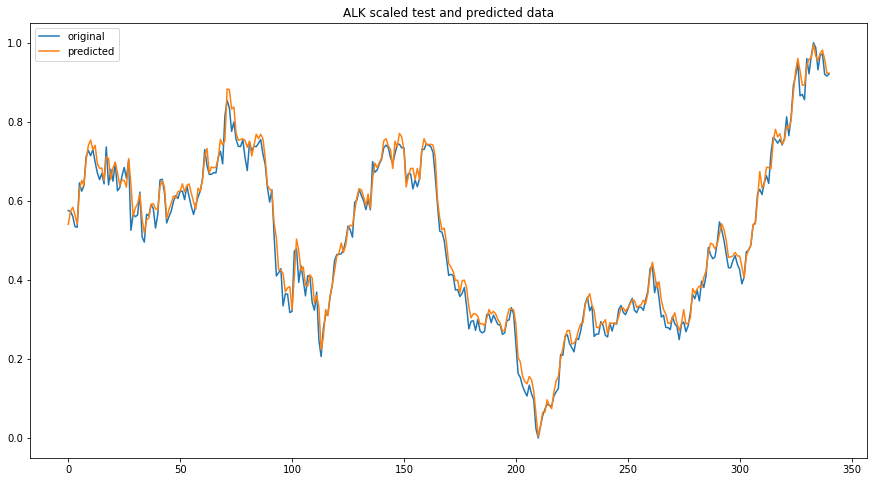

In [161]:
x_axis = range(len(ALKytest_scaled))
plt.plot(x_axis, ALKytest_scaled, label='original')
plt.plot(x_axis, test_scaled_ALK_final, label='predicted')
plt.title('ALK scaled test and predicted data')
plt.legend()
plt.show()